In [1]:
# Importing libraries 
import numpy as np
import emcee as em
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import subprocess
import os
import sys

In [3]:
current_directory = os.getcwd()

In [4]:
#metre une erreur pour jetfit si on est out ouf bounds et paser à la suite?
#bien revoir les paths de boxfit avant de mettre en public et redire quels paths changer quand boxfit s'installe

In [5]:
# Dictionnary containing all the parameters, all models will read of of this dictionnary

D = {
     # Lightcurve and spectrum settings
     'nu_0': 3e9, # ! Lowest frequency for spectrum, frequency for light curve (Hz)
     'nu_1': 1e21, #! Highest frequency for spectrum (Hz)
     't_0': 1.7e5,  #! Earliest time for light curve, time for spectrum (s)
     't_1':  9.5e7, #  ! Latest time for light curve (s)
     'no_points': 100, # ! how many data points in the light curve / spectrum

    # Jet parameters
     'E': 1.0208249320351635e+53,                  #
     'n': 1e-2,                #
     'theta_0': 0.0698132,
     'theta_obs': 0.44,
     'p': 2.15,
     'd_L': 1.2e26,              #observer luminosity distance (cm)
     'z': 0.00973,               #redshift

     # Environment
     'k': 0,                                  # (ISM) wind power index
     'A': 0, 

     # Microphysics
    'epsilon_B': 7e-6, # ! magnetic field energy fraction
    'epsilon_E': 1e-1,# ! accelerated particle energy density fraction
    'ksi_N': 1,    #    ! accelerated particle number density fraction
    
     # Boxfit commands and resolution settings
     'what_to_do': 1, #if 1 or 2 lightcurve, spectra
     'eds_r_res': 100,           #number of rays in EDS r direction
     'eds_phi_res': 30,
     'fluid_res': 100,

     #Afterglowpy 
     'b': 4.5,

     #JetFit
     'Eta0': 8,                                          #8
     'GammaB': 12, 
     'lf': 300,

       }

In [6]:
# Boundaries for time and frequency from the D dictionnary
t_min = D['t_0']
t_max = D['t_1'] 

nu_min = D['nu_0']
nu_max = D['nu_1']

points = int(D['no_points'])

In [7]:
#The arrays for times and frequencies
times = np.geomspace(t_min, t_max, points)
freqs = np.geomspace(nu_min, nu_max, points)

freq = np.ones(freqs.shape)*t_min
time = np.ones(times.shape)*nu_min

In [8]:
#Converts E to Eiso
def convert_E_Eiso(E,theta):
    Eiso = E/(1-np.cos(theta))  #Theta being the half opening angle of the jet
    print(E, np.cos(theta))
    return Eiso 

In [9]:
#Converts Eiso to E
def convert_Eiso_E(Eiso,theta):
    E = Eiso*(1-np.cos(theta)) #Theta being the half opening angle of the jet
    return E 

In [10]:
print(convert_E_Eiso(2.5*10**50,0.07))

2.5e+50 0.9975510002532796
1.0208249320351635e+53


In [11]:
#Converts time in s to time in days
def convert_ts_td(t):
    return t/(60*60*24)

In [12]:
#Calculate the lorentz factor 
def calc_lf(eta_0, gamma_B):
    gamma = 2*eta_0*gamma_B
    return gamma

# BoxFit

In [13]:
def case_read():
    # Importing the files from BOXFIT
    lightcurve_box = os.path.join(current_directory, 'boxfitcode', 'lightcurve.txt')        #For the lightcurve
    # spectrum_box = os.path.join(current_directory, 'boxfitcode', 'spectrum.txt')          #For the spectrum

    tbox, nubox, Flbox, Fnubox =  [], [], [], []

    def read_data_box(f, lightcurve = True): #lightcurve = true when getting the lightcurve data, lightcurve = false for the spectrum
        #Dummy index
        i = 0

        #Loop on the line
        for line in f:

            #Ignore line if it's a comment
            if line.startswith('#'):
                i = i + 1
                continue  # The loop restarts
        
            #Split line into columns and remove the commas
            columns = line.strip().replace(',','').split()  

            #Add data to lists
            tbox.append(float(columns[1]))
            nubox.append(float(columns[2]))        
            if lightcurve == True:
                Flbox.append(float(columns[3]))
            else:
                Fnubox.append(float(columns[3]))
                
            

    # To read the data from Boxfit and plot it 
    with open(lightcurve_box, 'r') as f1:
        read_data_box(f1, lightcurve=True)  #Getting the lightcurve

    # with open(spectrum_box, 'r') as f2:
    #     read_data_box(f2,lightcurve=False)  #Getting the spectrum

    # Convert lists to arrays
    tbox = np.array(tbox)       #Just here to make sure it's the same as the linspace tl
    nubox = np.array(nubox)     #Same for nus
    #Fnubox = np.array(Fnubox)
    Flbox = np.array(Flbox)

    return tbox, nubox, Flbox


In [14]:
value = int(input("Enter 1 to run boxfit and 2 to read boxfit output file"))
print(value)

1


In [15]:
match value:

    case 1:
        print("You have chosen to run boxfit here, please wait until the program is completed.")

        # Importing the path to the boxfitsettings file 
        settings = os.path.join('boxfitcode', 'boxfitsettings.txt')

        # Read the content of boxfitsettings.txt
        with open(settings, 'r') as file:
            settings_content = file.readlines()

            # Modify some lines according to the D disctionary
            for index, line in enumerate(settings_content):

                # Check if line is not an overall comment, has an equal and a comment to describe the parameter
                if not line.strip().startswith('!') and '=' in line and '!' in line:
                    keyval_extra = line.strip().split('!')                          #Split the key and value from the comment using the !
                    key_value = keyval_extra[0].split('=')                          #Split the key from the value using the = 
                    key, value = key_value[0].strip(), key_value[1].strip()         #Store them
                    
                    if key in D:
                        # If the key is also in D, update the key with the new value from the D dictionary
                        value = D[key]
                        comment = keyval_extra[1]
                        settings_content[index] = f"{key} = {value} !{comment}\n"

        # Write down the new lines in the settings file 
        with open(settings, 'w') as file:
            file.writelines(settings_content)


        # Importing the path to the boxfit executable 
        boxfitcode = os.path.join('boxfitcode', 'boxfit')

        # Run Boxfit with the shell, using the new boxfitsettings parameter file and saving the output in a list
        with subprocess.Popen(["boxfitcode/boxfit", settings], stdout=subprocess.PIPE, text=True) as process:
            output_boxfit = []
            for line in process.stdout:
                sys.stdout.write(line)      # Print the output to see the progression
                output_boxfit.append(line)  # Store the output
                
        # Saving BoxFit's output as three arrays: time, frequency and flux
        times_box, freq_box, Fl_box = [], [], []
        for line in output_boxfit:
            if not line.startswith('#'):                # Check if line is not a comment
                output_list = line.strip().split(',')  
                times_box.append(float(output_list[1]))
                freq_box.append(float(output_list[2]))
                Fl_box.append(float(output_list[3]))

        # Convert lists to arrays
        times_box = np.array(times_box) 
        freq_box = np.array(freq_box)     
        Fl_box = np.array(Fl_box)


    case 2:
        print("You have chosen to read boxfit output, please make sure the lightcurve.txt file is in the boxfitcode folder.")

        times_box, freq_box, Fl_box = case_read()


    case _:
        print("Please select either 1 to run BoxFit or 2 to read BoxFit output file.")

You have chosen to run boxfit here, please wait until the program is completed.
#######################################################
#              BOX-FIT. Release 2 
# Last modified: July 29, 2016, by HJvE 
#
# reference: "Gamma-ray burst afterglow broadband 
#   fitting based directly on hydrodynamics simulations"
#   H.J. van Eerten, A.J. van der Horst, A.I. MacFadyen
#   ApJ (2012) Issue 749, Page 44
#   ArXiv: 1110.5089
#
# Development of the Boxfit code was supported in part 
# by NASA through grant NNX10AF62G issued through the 
# Astrophysics Theory Program and by the NSF through 
# grant AST-1009863.
#######################################################
# function call:  boxfitcode/boxfit boxfitcode/boxfitsettings.txt
# Loading 34 BOXES ...done. First box has version 2.00
# BOXFIT Compiled WITHOUT boosted frames support
# I/O settings:
#   using parameter file boxfitcode/boxfitsettings.txt
#   base filename BOX files: /home/agath/snap/firefox/common/Downloads/boxfitv2/da

# Afterglowpy

In [16]:
import afterglowpy as grb

In [17]:
#Afterglowpy dictionary contining the specifics of the jet and environment parameters
A = {'jetType':     grb.jet.TopHat,     # Top-Hat jet
     'specType':    0,                  # Basic Synchrotron Spectrum
     'thetaWing':   2*D['theta_obs'],   # Outer truncation angle
     'thetaObs':    D['theta_obs'],     # Viewing angle in radians, (roughly 20 degrees)
     'E0':          D['E'],             # Isotropic-equivalent energy in erg
     'thetaCore':   D['theta_0'],       # Half-opening angle in radians
     'n0':          D['n'],             # circumburst density in cm^{-3}
     'p':           D['p'],             # electron energy distribution index
     'epsilon_e':   D['epsilon_E'],     # epsilon_e
     'epsilon_B':   D['epsilon_B'],     # epsilon_B
     'xi_N':        D['ksi_N'],         # Fraction of electrons accelerated
     'd_L':         D['d_L'],           # Luminosity distance in cm (40Mpc)
     'z':           D['z'],             # redshift
     'b':           D['b']              # power for power-law structure theta**(-b)
     }                



In [18]:
def light_curve_afterglowpy(A):
    # Calculate the fluxes
    Fnula = grb.fluxDensity(times, freq, **A)   # For the lightcurve
    Fnusa = grb.fluxDensity(time, freqs, **A)   # For the spectrum

    return Fnula, Fnusa

Fnula, Fnusa = light_curve_afterglowpy(A)

In [19]:
#Get multiple geometries from Afterglowpy

#Here are all the types of jets and their names
types_jets = [grb.jet.TopHat, grb.jet.Gaussian, grb.jet.PowerLaw,  grb.jet.GaussianCore, grb.jet.PowerLawCore]
name_types_jets = ['TopHat', 'Gaussian', 'PowerLaw', 'GaussianCore','PowerLawCore']

#Make a loop over them and store the fluxes for each jet
afterglowpys = [light_curve_afterglowpy(A) for A['jetType'] in types_jets]

# JetFit

In [20]:
jetfitcode_path = os.path.join(current_directory, 'jetfitcode')
sys.path.append(jetfitcode_path)

from FitterClass import *
from FluxGeneratorClass import *
from collections import defaultdict

In [21]:
#Importing the precomputed fluxes to put in the JetFit functions
Table = os.path.join(jetfitcode_path, 'Table.h5') 

In [22]:
#Function that removes the logscales
def Log2Linear(Log, Info):
    Linear = {} #Defined as a dictionary
    for i, key in enumerate(Info['Fit']):   #Going through all the parameters
        if key in Info['Log']:              #If it is in logscale, then use the exponential or 10^X
            if Info['LogType'] == 'Log10':
                Linear[key] = np.power(10.,Log[key])
            else:
                Linear[key] = np.exp(Log[key])
        else:
            Linear[key] = Log[key]
    # print(Linear['E'],Linear) #Debug statement to see the full dict
    return Linear


In [23]:
#Calculates the range for time with respect to the bounds of tau for jetfit

def range_time_tau():
    #The range and formula from the paper
    tau_min = 8.64e2
    tau_max = 8.64e7
    scale = (1. + J['z'])*(J['E']/J['n'])**(1./3.)
    ti = tau_min*scale
    tf = tau_max*scale

    print('The time range allowed by tau is: [',"{:e}".format(ti),',',"{:e}".format(tf),']')

    if t_min < ti:
        print('The lower boundary is out of bounds:', "{:e}".format(t_min), 'is lower than', "{:e}".format(ti))
    elif t_max > tf:
        print('The upper boundary is out of bounds:', "{:e}".format(t_max),'is higher than', "{:e}".format(tf))
    else:
        print('The values are within the time range.')
    return ti, tf

In [24]:
def light_curve_jetfit(P):
    #Call to the function to know if we are in the domain of validity of JetFit
    ti, tf = range_time_tau()
    
    #Calculate flux
    flux_jet = np.asarray(FluxGenerator.GetSpectral(times, freq, P))

    return flux_jet

In [25]:
def get_integrated_jetfit(P):

    #The function takes as an input an array with two columns, so we split the data into two arrays with points (because points/2 fails)
    mid_point = freqs[int(points/2)]
    nus_col = np.column_stack((np.geomspace(nu_min, mid_point, points), np.geomspace(mid_point, nu_max, points)))
    
    #Calculate flux
    Fsjet = np.asarray(FluxGenerator.GetIntegratedFlux(time, nus_col, P))

    return nus_col, Fsjet

In [26]:
#JetFit informations
Info = {
    'Fit': np.array(['E', 'Eta0', 'GammaB','theta_obs','epsb','epse','n','p','z','xiN','dL','theta_obs']),  # Fitting parameters (Parameter names see P dictionary below)
    'Log': np.array([]),                                                                                    # Set parameters in log scale 'E','n','epse','epsb' (mesured in log for mcmc analysis)
    'LogType': 'Log10',                                                                                     # Log scale type: Log10 or Log
    'ThetaObsPrior': 'Sine',                                                                                # Prior for observation angle: Sine or Uniform
    'FluxType': 'Spectral'                                                                                  # Flux type: Spectral or Integrated
}

#JetFit bounds for parameters in linear scale
FitBound = {
    'E': np.array([1e-6, 1e3]),         
    'n': np.array([1e-6, 1e3]),
    'Eta0': np.array([2.,10.]),
    'GammaB': np.array([1.,12.]),
    'theta_obs': np.array([0.,1.]),
    'epse': np.array([1e-6,1.]),
    'epsb': np.array([1e-6,1.]),
    'p': np.array([2.,4.])
}

#JetFit dict
Explore = False # For non-fiting parameters, P set default values. 

J = {
    'E': convert_Eiso_E(D['E'],D['theta_0'])/10**50,    # E0/10^50, need to convert because B takes Eiso as an input 
    'Eta0': D['Eta0'],                                          #8
    'GammaB': D['GammaB'],                                       #12
    'dL': D['d_L']/10**28,                              # dl/10^28 cm
    'epsb': D['epsilon_B'],
    'epse': D['epsilon_E'],
    'n': D['n'],                                        # has no unit because cm^{-3}/1cm^{-3}
    'p': D['p'],
    'theta_obs': D['theta_obs'],                        # This is the half opening angle
    'xiN': D['ksi_N'],
    'z': D['z']
}

#Transform the log variables from the P dictionnary to linear ones
J = Log2Linear(J,Info) 

#Create FluxGeneratorClass based on the given table
FluxGenerator = FluxGeneratorClass(Table)

#Get the lightcurve from the function
Fljet = light_curve_jetfit(J)

#Get the integrated lightcurve from the function
nusj, Fsjet = get_integrated_jetfit(J)

The time range allowed by tau is: [ 5.486040e+03 , 5.486040e+08 ]
The values are within the time range.
Made it to the if
break1
break2
sucessfully through the if
Made it to the if
Made it to the exept


# JetSimpy

In [27]:
import jetsimpy

In [28]:
JS = dict(
    Eiso = 1.0208249320351635e+53,                          # (Jet) Isotropic equivalent energy
    lf = calc_lf(D['Eta0'], D['GammaB']),   # (Jet) Lorentz factor
    theta_c = D['theta_0'],                 # (Jet) half opening angle
    n0 = D['n'],                            # (ISM) constant number density
    k = D['k'],                                  # (ISM) wind power index
    A = D['A'],                                  # (ISM) wind amplitude
    eps_e = D['epsilon_E'],                 # (Radiation) epsilon_e
    eps_b = D['epsilon_B'],                 # (Radiation) epsilon_b
    p = D['p'],                             # (Radiation) electron power index
    theta_v = D['theta_obs'],               # (Radiation) viewing angle
    d = D['d_L']/3.08e24,                   # (radiation) distance (Mpc)
    z = D['z'],                             # (radiation) redshift
    b = 1,                                  # (radiation) magnetic field anisotropy
)

In [29]:
#Theta Linspace
theta = np.linspace(0, np.pi, 1000) 

#Constructing the Eiso linspace
theta_c = D['theta_0']
b = A['b']
E_0 = 1.0208249320351635e+53
gb = D['GammaB']
e0 = D['Eta0']

# Top Hat np.heaviside(-thetalinsp+theta_c,thetalinsp[999]- theta_c)
Eiso_th = E_0*np.heaviside(-theta+theta_c,theta[999]-theta_c) # Using the heaviside funcion that is 0 for x < 0 and 1 for x > 1 with x running from 1 to -9 to get only a small potion that is = 1 with sharp edges

# Gaussian
Eiso_g = E_0*np.exp(-0.5*(theta/theta_c)**2) 

# Power-Law
Eiso_pl = E_0*( 1 + (1/b)*(theta/theta_c)**2 )**(-b/2)

# Boosted Fireball
v0 = np.sqrt(1 - 1/e0**2)
vb = np.sqrt(1 - 1/gb**2) 
sin_fact = gb*vb*np.sin(theta) #convert_deg_to_rad(thetalinsp)
gamma_max_0 = gb*(e0 + vb*e0*v0)
gamma_max = gb*(e0 + vb*np.cos(theta))*np.sqrt((e0*v0)**2 - sin_fact**2)/(1 + sin_fact**2)
#Eiso = (E_0/4*np.pi)*(gamma_max/gamma_max_0)**3

#Eiso = B["E"] * np.exp(- 0.5 * (theta / B["theta_0"]) ** 2)

# Lorentz fator
lf = (calc_lf(D['Eta0'], D['GammaB']) - 1) * np.exp(- 0.5 * (theta / D["theta_0"]) ** 2) + 1

/tmp/ipykernel_19942/910133170.py:25: RuntimeWarning: invalid value encountered in sqrt
  gamma_max = gb*(e0 + vb*np.cos(theta))*np.sqrt((e0*v0)**2 - sin_fact**2)/(1 + sin_fact**2)


In [30]:
def flux_jetsimpy(theta, Eiso, lf):
    # jet with spreading (show full argument and keyword list)
    theta, Eiso, lf = jetsimpy.Gaussian(D["theta_0"], D["E"], lf0=D["lf"])
    jet = jetsimpy.Jet(
        (theta, Eiso, lf),             # [tuple of tabulated data]: (polar angles, rest mass excluded energy, Lorentz factor)
        D["A"],                        # [wind density scale]: n = nwind * (r / 1e17)^-2 + nism (cm^-3)
        D["n"],                       # [ism density scale]: n = nwind * (r / 1e17)^-2 + nism (cm^-3)
        t_min,                     # [simulation start time]: (s)
        t_max,                    # [simulation end time]: (s)
        grid=jetsimpy.NorthPole(D["theta_0"], 129),    # [cell edge angles]: must start with 0 and end with pi.
        tail=True,                     # [isotropic tail]: add an extremely low energy low velocity isotropic tail for safty
        spread=True,                   # w/wo spreading effect 
        cal_level=1,                   # [calibration level]: 0: no calibration. 1: BM all time. 2: smoothly go from BM to ST (dangerous)
        rtol=1e-6,                     # [primitive variable solver tolerance]: Don't change it unless you know what is going on.
        cfl=0.9,                       # [cfl number]: Don't change it unless you know what is going on.
    )
    # calculate the afterglow flux density (unit: mJy)
    Fl_js = jet.FluxDensity(
        times,                 # [second] observing time span
        freq,                # [Hz]     observing frequency
        JS,                 # parameter dictionary for radiation
        rtol=1e-2,          # (default=1e-2) integration error tolerance
        model="sync",       # default radiation model
    )
    return Fl_js

In [31]:
energy_jets = [Eiso_th, Eiso_g, Eiso_pl]
jetsimpys = [flux_jetsimpy(theta, Eiso, lf) for Eiso in energy_jets] 

RuntimeError: EATS: Observing time exceeds PDE maximum evolution time!


# Get the data points from an event 

In [ ]:
# Getting the data from GW170817
gw = os.path.join(current_directory, 'data', 'GW170817_3GHz_VLAobs.txt')

#Declare lists for the variables
t_gw = []
nu_gw = []
Fl_gw = []
Flerr_gw = []

with open(gw,'r') as file:

    for line in file:
        #Ignore the comments in the file
        if line.startswith('#'): 
            continue
        
        #Split line into columns and remove the spaces
        columns = line.strip().split()  

        t_gw.append(float(columns[0]))
        Fl_gw.append(float(columns[1]))
        Flerr_gw.append(float(columns[2]))
        nu_gw.append(float(columns[3]))

# Convert lists to arrays
t_gw = np.array(t_gw) #Contrary to the others, the time is in days
Fl_gw = np.array(Fl_gw)
Flerr_gw = np.array(Flerr_gw)
nu_gw = np.array(nu_gw)        

## Plot the Lightcurves and Spectra

In [ ]:
print(convert_ts_td(times_box))

[   1.96759259   16.20665509  133.49085648 1099.53703704]


/tmp/ipykernel_94196/2893060074.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


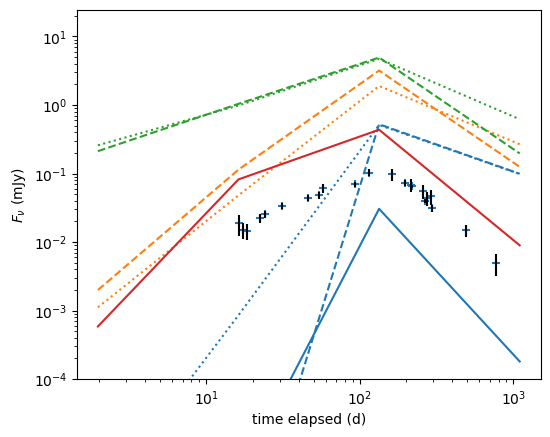

In [ ]:
#To get a Label
Label = {
    r'$E_{iso}$': D['E'],
    r'$n$': D['n'],
    r'$\eta_0$': D['Eta0'],
    r'$\gamma_B$': D['GammaB'],
    r'$\theta_{obs}$': D['theta_obs'],
    r'$\epsilon_e$': D['epsilon_E'],
    r'$\epsilon_b$': D['epsilon_B']
}

labels = ["{}: {}".format(key, value) for key, value in Label.items()]


#Instructions for plotting the lightcurve

fig1, ax1 = plt.subplots(1, 1)

# Top Hat
ax1.plot(convert_ts_td(times_box), Fl_box, label="BoxFit") #convert_ts_td(tbox)
ax1.plot(convert_ts_td(times), afterglowpys[0][0], label="Afterglowpy (Top Hat)", color = 'tab:blue', linestyle='dashed')
ax1.plot(convert_ts_td(times), jetsimpys[0], label="JetSimpy (Top Hat)", color = 'tab:blue', linestyle='dotted') #convert_ts_td(tlj)

#Gaussian
ax1.plot(convert_ts_td(times), afterglowpys[1][0], label="Afterglowpy (Gaussian)", color = 'tab:orange', linestyle='dashed')
ax1.plot(convert_ts_td(times), jetsimpys[1], label="JetSimpy (Gaussian)", color = 'tab:orange', linestyle='dotted') #convert_ts_td(tlj) 

#Power-Law
ax1.plot(convert_ts_td(times), afterglowpys[2][0], label="Afterglowpy (Power-Law)", color = 'tab:green', linestyle='dashed')
ax1.plot(convert_ts_td(times), jetsimpys[2], label="JetSimpy (Power-Law)", color = 'tab:green', linestyle='dotted') #convert_ts_td(tlj)


#Boosted ireball (JetFit)
ax1.plot(convert_ts_td(times), Fljet, label="JetFit", color = 'tab:red') #convert_ts_td(tlj) Fljet*1e-6


# Afterglowpy for every jet type
#[ax1.plot(convert_ts_td(tl), afterglowpys[i][0], label= f"Afterglowpy ({name_types_jets[i]})", linestyle='dashed') for i in range(3)] #convert_ts_td(tl) #len(afterglowpys)
#ax1.plot(convert_ts_td(tl), Fnula, label="Afterglowpy") #convert_ts_td(tl)


#Event data with its errorbars
ax1.scatter(t_gw, Fl_gw, label = "GW170817", marker = '+')
ax1.errorbar(t_gw, Fl_gw,yerr=Flerr_gw,linestyle='', color='black')

#DeepGlow
#ax1.plot(convert_ts_td(tl), Fldeep , label="DeepGlow")

#ax1.set_title("{}".format(",".join(labels)))
ax1.set(xscale='log', xlabel=r'time elapsed (d)',
       yscale='log', ylabel=r'$F_\nu$ (mJy)')
#ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_ylim(10**-4,)
plt.subplots_adjust(right=0.85)
fig1.savefig("lightcurve_comp.pdf", bbox_inches='tight')

fig1.show()

# #Instructions for plotting the spectrum

# fig2, ax2 = plt.subplots(1, 1)
# [ax2.plot(nus, afterglowpys[i][1], label= f"Afterglowpy ({name_types_jets[i]})", linestyle='dashed') for i in range(len(afterglowpys))] #convert_ts_td(tl)
# #ax2.plot(nus, Fnusa, label="Afterglowpy")
# ax2.plot(nus, Fnubox, label="BoxFit")
# ax2.plot(nusj, Fsjet, label="JetFit")
# ax2.set_title("Spectrum from different models")
# ax2.set(xscale='log', xlabel=r'$\nu$ (Hz)',
#        yscale='log', ylabel=r'$F_\nu$ (mJy)')
# ax2.legend()
# fig2.savefig("spectrum_comp.png")
#fig2.show()



### Table of the input of each model

This table indicates the input of each model with its units (or a . when there's no unit). 

| Input Parameter | BoxFit | Afterglowpy | JetFit | JetSimpy |
|:--------:|:--------:|:--------:| :--------:| :--------:|
|  $\theta_{obs}$   | . rad   | . rad  |   | . rad  |
|  $\theta_{j}$    | . rad   |  . rad  |   | . rad  |
|  $\theta_{wing}$    |    |  rad   |   |  |
|  $n$    | . $cm^{-3}$   | . $cm^{-3}$   | . $cm^{-3}$/1 $cm^{-3}$  | . $cm^{-3}$   |
|  $p$    |  .  |  .   | .   | .  |
|  $E$   |     |     | . erg / 10^50   |    |
|  $E_{iso}$   |  . erg   | . erg   |   | . erg   |
|  $\eta_0$   |     |    | .   |    |
|  $\gamma_B$    |     |    | .   |    |
|  $\Gamma$    |     |    |    | .  |
|  $\epsilon_B$   |  .  |  .   | .   | .  |
|  $\epsilon_E$   |  .   |  .  | .  | .  |
|  $\xi_N$   |  .  |  .   | .   |   |
|  $d_L$   |  cm   |  cm   | cm  | Mpc   |
|  $z$   |  .  |  .   | .   | .  |
|  $b$   |    |  .   |   | .  |

Table of the inputs of each model for generating the lightcurves above.

In [ ]:
import pandas as pd

models = {
    "BoxFit": [D['theta_obs'], D['theta_0'], '', '', '', '', '', D['E'], D['n'], D['p'], '', D['epsilon_E'], D['epsilon_B'], D['ksi_N'], D['d_L'], D['z']],
    "Afterglowpy": [A['thetaObs'], A['thetaCore'], A['thetaWing'], '','', '', '', A['E0'], A['n0'], A['p'], A['b'], A['epsilon_e'], A['epsilon_B'], A['xi_N'], A['d_L'], A['z']],
    "JetFit": ['', '','', J['Eta0'], J['GammaB'], '', format(J['E'],'.2e'), '', J['n'], J['p'], '', J['epse'], J['epsb'], J['xiN'], J['dL'], J['z']],
    "JetSimpy": [JS['theta_v'], JS['theta_c'], '', '', '', JS['lf'], '', JS['Eiso'], JS['n0'], JS['p'], JS['b'], JS['eps_e'], JS['eps_b'], '', format(JS['d'],'.2e'), JS['z']]
}

# The format is the following:
# "Model": [D['thetaObs'], D['thetaCore'], D['thetaWing'], D['Eta0'], D['GammaB'], D['E'], D['Eiso'], D['n0'], D['p'], D['b'], D['epsilon_e'], D['epsilon_B'], D['xi_N'], D['d_L'], D['z']]

variables = ['theta_obs','theta_j', 'theta_wing', 'eta_0', 'gamma_B', 'lf', 'E', 'E_iso', 'n', 'p', 'b', 'eps_e', 'eps_b', 'xi_N', 'd_L', 'z']

variables_unit_B = [' rad', ' rad', '', '', '', '','', ' erg', ' cm^-3', '', '', '', '', '', ' cm', '']
variables_unit_A = [' rad', ' rad', ' rad', '', '', '','', ' erg', ' cm^-3', '', '', '', '', '', ' cm', '']
variables_unit_J = ['', '', '', '', '', '',' erg/10^50', '', '', '', '', '', '', '', ' cm/10^28', '']
variables_unit_JS = [' rad', ' rad', '', '', '', '', '',' erg', ' cm^-3', '', '', '', '', '', ' Mpc', '']

df = pd.DataFrame(models, variables)
df['BoxFit'] = df['BoxFit'].astype(str) + variables_unit_B
df['Afterglowpy'] = df['Afterglowpy'].astype(str) + variables_unit_A
df['JetFit'] = df['JetFit'].astype(str) + variables_unit_J
df['JetSimpy'] = df['JetSimpy'].astype(str) + variables_unit_JS

print(df)

                                BoxFit                 Afterglowpy  \
theta_obs                     0.44 rad                    0.44 rad   
theta_j                  0.0698132 rad               0.0698132 rad   
theta_wing                                                0.88 rad   
eta_0                                                                
gamma_B                                                              
lf                                                                   
E                                                                    
E_iso       1.0208249320351635e+53 erg  1.0208249320351635e+53 erg   
n                           0.01 cm^-3                  0.01 cm^-3   
p                                 2.15                        2.15   
b                                                              4.5   
eps_e                              0.1                         0.1   
eps_b                            7e-06                       7e-06   
xi_N                

### Attempt to verify that only the ratio $\theta_{obs}$/$\theta_j$ is constrained

In [ ]:
def time_flux_peaks(Fnu, t):
    
    Fnu_peak = np.max(Fnu)
    t_peak = t[np.argmax(Fnu)]

    return Fnu_peak, t_peak

In [ ]:
import random

print(np.random.uniform(1,10))
#Rescaling as in Nakar

def rescaling( theta_obs, theta_0,E, n, epse, nu, d_L,p, Fl, t, ): #maybe change this with **kwargs but beware that not all dictionnaries have the same key name for the same physical variable (or the same scale, check jetfit)

    #Get the old ratio, should be constrained between 10 and 3
    ratio = theta_obs/theta_0
    print('The ratio is', ratio)

    #Get the new angle values with the same ratio, theta_obs contrained between 0 and 1.57, theta_0 between 0.045 and 0.5, wrote a statement in case out of bounds
    theta_obs_re = np.random.uniform(0.045*ratio,1.57)
    theta_0_re = theta_obs_re/ratio

    if theta_0_re > 0.5 or theta_0_re < 0.045:
        print('Random theta j out of bounds for this ratio and theta obs', theta_0_re)

    #Get the previous t_peak and f_peak
    Fl_peak, t_peak = time_flux_peaks(Fl, t)

    #Get the new t_peak and F_peak
    n_re = (((theta_obs_re - theta_0_re)**2*E**(1/3))/t_peak)**(1/3)
    epsb_re = ((Fl_peak)/E*(n**(p+1/4))*(epse**(p-1))*(theta_obs**(-2*p))*(nu**(-(p-1)/2))*(d_L**-2))**(4/p+1)

    #Calculate the 
    return theta_obs_re, theta_0_re, epsb_re, n_re

8.164637406157533


In [ ]:
rescaling(D['theta_obs'], D['theta_0'], D['E'], D['n'], D['epsilon_E'], freqs[0], D['d_L'], D['p'], Fl_box, time_box)

NameError: name 'time_box' is not defined

### Attempt to calculate the flux peak for every model

In [ ]:
# Variables
E = B['E']
n = B['n']
p = B['p']
eps_e = B['epsilon_E']
eps_B = B['epsilon_B']
d = B['d_L']
nu = nul[0]
theta_obs = B['theta_0']

def flux_peak(F):
    actual_peak = np.amax(F)
    flux_peak = E*np.power(n,(p+1)/4)*np.power(eps_e,p-1)*np.power(eps_B,(p+1)/4)*np.power(theta_obs,-2*p)*np.power(nu,-(p-1)/2)*np.power(d,-2)
    constant = flux_peak/actual_peak
    return flux_peak, constant

#flux_peak, constant = flux_peak(Flbox)
#print(flux_peak, constant)

print(np.amax(Fljet))
abcdefg, hijklmn = flux_peak(Fljet)
#print(flux_peak_jet, constant_jet)
print(abcdefg, hijklmn)

0.10460664450890762
3.871036958265211e-07 3.7005650801996416e-06


## Plotting E($\theta$) for every jet structure

In [ ]:
def convert_deg_to_rad(deg):
    return deg*np.pi/180

In [ ]:
def convert_rad_to_deg(rad):
    return rad*180/np.pi

In [ ]:
convert_deg_to_rad(10)

0.17453292519943295

In [ ]:
thetalinsp = np.linspace(0, 0.6981317007977318, 1000)

# Fetching the variables

theta_c = 0.0698132 # 10 degrees 0.17453292519943295
b = A['b']
E_iso = B['E']
gb = J['GammaB']
e0 = J['Eta0']
c = 3*10**8 #speed of light in vacuum 

# Top Hat
E_th = np.heaviside(-thetalinsp+theta_c,thetalinsp[999]- theta_c) # Using the heaviside funcion that is 0 for x < 0 and 1 for x > 1 with x running from 1 to -9 to get only a small potion that is = 1 with sharp edges

# Gaussian
E_g = np.exp(-0.5*(thetalinsp/theta_c)**2) 

# Power-Law
E_pl = ( 1 + (1/b)*(thetalinsp/theta_c)**2 )**(-b/2)

# Boosted Fireball
v0 = np.sqrt(1 - 1/e0**2)
vb = np.sqrt(1 - 1/gb**2) 
sin_fact = gb*vb*np.sin(thetalinsp)
gamma_max_0 = gb*(e0 + vb*e0*v0)
gamma_max = gb*(e0 + vb*np.cos(thetalinsp))*np.sqrt((e0*v0)**2 - sin_fact**2)/(1 + sin_fact**2)
E_bf = (gamma_max/gamma_max_0)**3


In [ ]:
def normalize_E(E):
    return E/E[0]

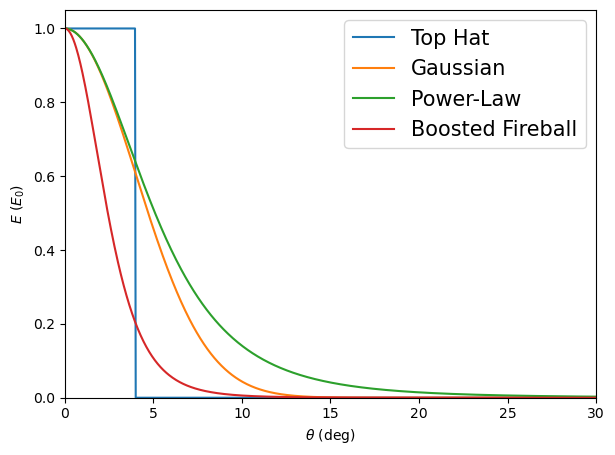

In [ ]:
fig3, ax3 = plt.subplots(1, 1)
plt.rcParams.update({'font.size': 15})
ax3.plot(convert_rad_to_deg(thetalinsp), E_th, label="Top Hat")
ax3.plot(convert_rad_to_deg(thetalinsp), E_g, label="Gaussian") 
ax3.plot(convert_rad_to_deg(thetalinsp), E_pl, label="Power-Law") 
ax3.plot(convert_rad_to_deg(thetalinsp), normalize_E(E_bf), label="Boosted Fireball") 
ax3.set_xlim(0,30)
ax3.set_ylim(0,)
#ax3.set_title("Energy per angle of structured jets")
ax3.set(xlabel=r'$\theta$ (deg)', ylabel=r'$E$ ($E_0$)')
ax3.legend()
plt.tight_layout()
fig3.savefig("profiles.png")